In [1]:
for name in dir():
 if not name.startswith("_"):
   del globals()[name]

#Import necessary packages
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import graphviz
import itertools

from scipy.stats import ks_2samp
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from scipy import interp
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from joblib import Parallel, delayed

In [107]:
df_sample = pd.read_csv("data/sample_submission.csv", header="infer")
print(df_sample.shape)
print(df_sample.head())
print(df_sample.tail())

(506691, 2)
   TransactionID  isFraud
0        3663549      0.5
1        3663550      0.5
2        3663551      0.5
3        3663552      0.5
4        3663553      0.5
        TransactionID  isFraud
506686        4170235      0.5
506687        4170236      0.5
506688        4170237      0.5
506689        4170238      0.5
506690        4170239      0.5


In [108]:
random_probs = np.random.uniform(0, 1, 506691)
df_random = df_sample.copy()
df_random['isFraud'] = random_probs

In [109]:
print(df_random.shape)
print(df_random.head())
print(df_random.tail())

(506691, 2)
   TransactionID   isFraud
0        3663549  0.777565
1        3663550  0.330396
2        3663551  0.409880
3        3663552  0.620834
4        3663553  0.159737
        TransactionID   isFraud
506686        4170235  0.583579
506687        4170236  0.593995
506688        4170237  0.623146
506689        4170238  0.638177
506690        4170239  0.451321


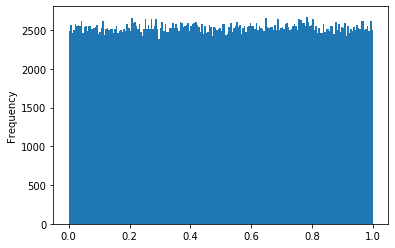

In [110]:
df_random['isFraud'].plot(kind='hist', bins=200)

In [46]:
df_random.to_csv('data/random_out.csv', header=True, index=False)

In [2]:
df_identity_train = pd.read_csv("data/train_identity.csv", header="infer")
df_identity_test = pd.read_csv("data/test_identity.csv", header="infer")

In [3]:
df_transaction_train = pd.read_csv("data/train_transaction.csv", header="infer")
df_transaction_test = pd.read_csv("data/test_transaction.csv", header="infer")

In [4]:
print(df_identity_train.shape)
print(df_transaction_train.shape)

print(df_identity_test.shape)
print(df_transaction_test.shape)

(144233, 41)
(590540, 394)
(141907, 41)
(506691, 393)


In [5]:
df_identity_train.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28     id_29             id_30                id_31  id_32      id_33           id_34 id_35 id_36 id_37 id_38 DeviceType                     DeviceInfo
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New  NotFound       Android 7.0  samsung browser 6.2   32.0  2220x1080  match_status:2     T     F     T     T     mobile  SAMSUNG SM-G892A Build/NRD90M
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New  NotFound        iOS 11.1.2   mobile safari 11.0   32.0   1334x750  match_status:1     T     F     F     T     mobile                     iOS Device
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found     Found               NaN          chrome 62.0    NaN        NaN             NaN     F     F     T     T    desktop                        Windows
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN  176.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New  NotFound               NaN          chrome 62.0    NaN        NaN             NaN     F     F     T     T    desktop                            NaN
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN    0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0  529.0  575.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found     Found  Mac OS X 10_11_6          chrome 62.0   24.0   1280x800  match_status:2     T     F     T     T    desktop                          MacOS

In [6]:
df_transaction_train.head(20)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14     D1     D2    D3     D4    D5   D6   D7    D8   D9    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8   M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95   V96   V97  V98   V99  V100  V101  V102  V103  V104  V105  V106  V107  V108  V109  V110  V111  V112  V113  V114  V115  V116  V117  V118  V119  V120  V121  V122  V123  V124  V125  V126    V127   V128  V129   V130   V131  V132    V133   V134  V135  V136  V137  V138  V139  V140  V141  V142  V143  V144   V145  V146  V147  V148  V149    V150  V151  V152  V153  V154  V155  V156  V157  V158          V159           V160  V161  V162  V163   V164    V165    V166  V167  V168  V169  V170  V171  V172  V173  V174  V175  V176  V177  V178  V179  V180  V181  V182  V183  V184  V185  V186  V187  V188  V189  V190  V191  V192  V193  V194  V195  V196  V197  V198  V199  V200  V201        V202        V203        V204       V205       V206       V207       V208       V209       V210  V211  V212  V213       V214       V215       V216  V217  V218  V219  V220  V221  V222  V223  V224  V225  V226  V227  V228  V229  V230  V231  V232  V233  V234  V235  V236  V237  V238  V239  V240  V241  V242  V243  V244  V245  V246  V247  V248  V249  V250  V251  V252  V253  V254  V255  V256  V257  V258  V259  V260  V261  V262        V263        V264        V265       V266       V267       V268  V269       V270       V271       V272  V273  V274  V275       V276       V277       V278  V279  V280  V281  V282  V283  V284  V285  V286  V287  V288  V289  V290  V291  V292  V293  V294  V295  V296  V297  V298  V299  V300  V301  V302  V303  V304  V305        V306         V307        V308       V309        V310       V311        V312       V313        V314       V315  V316    V317   V318       V319        V320       V321  V322  V323  V324  V325  V326  V327  V328  V329  V330  V331  V332  V333  V334  V335  V336  V337  V338  V339
0         2987000        0          86400          68.500         W  13926    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN            NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0    NaN   NaN  NaN  NaN   NaN  NaN   13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0   0.0  0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   117.0    0.0   0.0    0.0    0.0   0.0   117.0    0.0   0.0   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           NaN            NaN   NaN   NaN   NaN    NaN     NaN     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

In [8]:
df_transaction_train['TransactionDT'] = df_transaction_train['TransactionDT'] - 86400

In [9]:
df_transaction_train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [10]:
df_transaction_train['TransactionID'].nunique()

590540

In [11]:
def check_missing(df):
    df_missing = pd.concat([df.nunique(), df.isnull().any(), df.isnull().sum()], axis=1)
    df_missing.columns = ['nunique', 'isnull_any', 'isnull_count']
    df_missing['missing'] = df_missing['isnull_count'] / float(len(df))
    return (df_missing)

In [12]:
df0 = df_transaction_train[ df_transaction_train['isFraud'] == 0 ]
df0_missing = check_missing(df0)

df1 = df_transaction_train[ df_transaction_train['isFraud'] == 1 ]
df1_missing = check_missing(df1)

In [13]:
df_missing = pd.merge(df0_missing, df1_missing, how="left", left_index=True, right_index=True)

In [14]:
df_missing

nunique_x  isnull_any_x  isnull_count_x  missing_x  nunique_y  isnull_any_y  isnull_count_y  missing_y
TransactionID      569877         False               0   0.000000      20663         False               0   0.000000
isFraud                 1         False               0   0.000000          1         False               0   0.000000
TransactionDT      553717         False               0   0.000000      20638         False               0   0.000000
TransactionAmt      20560         False               0   0.000000       2515         False               0   0.000000
ProductCD               5         False               0   0.000000          5         False               0   0.000000
card1               13350         False               0   0.000000       1740         False               0   0.000000
card2                 500          True            8510   0.014933        327          True             423   0.020471
card3                 106          True            1526   0.002678         62          True              39   0.001887
card4                   4          True            1536   0.002695          4          True              41   0.001984
card5                 118          True            4049   0.007105         49          True             210   0.010163
card6                   4          True            1532   0.002688          2          True              39   0.001887
addr1                 332          True           57965   0.101715         86          True            7741   0.374631
addr2                  68          True           57965   0.101715         17          True            7741   0.374631
dist1                2635          True          336363   0.590238        470          True           15908   0.769879
dist2                1723          True          535981   0.940520        344          True           16932   0.819436
P_emaildomain          59          True           91666   0.160852         42          True            2790   0.135024
R_emaildomain          60          True          443813   0.778787         32          True            9436   0.456662
C1                   1526         False               0   0.000000        497         False               0   0.000000
C2                   1075         False               0   0.000000        544         False               0   0.000000
C3                     27         False               0   0.000000          2         False               0   0.000000
C4                   1180         False               0   0.000000        224         False               0   0.000000
C5                    319         False               0   0.000000        124         False               0   0.000000
C6                   1270         False               0   0.000000        282         False               0   0.000000
C7                   1018         False               0   0.000000        197         False               0   0.000000
C8                   1115         False               0   0.000000        311         False               0   0.000000
C9                    205         False               0   0.000000        111         False               0   0.000000
C10                  1163         False               0   0.000000        234         False               0   0.000000
C11                  1400         False               0   0.000000        330         False               0   0.000000
C12                  1050         False               0   0.000000        282         False               0   0.000000
C13                  1567         False               0   0.000000        392         False               0   0.000000
C14                  1085         False               0   0.000000        244         False               0   0.000000
D1                    641          True            1223   0.002146        577          True              46   0.002226
D2                    641          True          268004   0.470284        541          Tr

In [15]:
column = 'M1'
column = 'card1'

print(df_transaction_train[df_transaction_train['isFraud'] == 0][column].value_counts())
print(df_transaction_train[df_transaction_train['isFraud'] == 1][column].value_counts())

7919     14820
9500     13634
17188    10066
15885     9917
15066     7632
12695     6890
12544     6627
6019      6477
2803      6068
7585      5071
12839     5059
10616     4970
3154      4328
18132     4150
2616      4096
15497     3934
16132     3865
2884      3821
11207     3650
16075     3566
10112     3525
9633      3416
7508      3394
12501     3084
10057     3044
7826      2929
16659     2920
12577     2864
7861      2718
6530      2706
7664      2665
8320      2610
7207      2510
5812      2504
5033      2503
4461      2487
10023     2385
7815      2370
10486     2364
9112      2329
15063     2203
16560     2073
4806      2043
7676      2025
16136     1998
12932     1934
4436      1930
1444      1925
17399     1894
11839     1884
13832     1866
2772      1864
14290     1729
1675      1723
2455      1710
11157     1696
9026      1679
17055     1652
3821      1635
1974      1584
1893      1576
17131     1570
18018     1554
1724      1516
8528      1499
2392      1490
15775     

In [16]:
df_transaction_train.describe()

TransactionID        isFraud  TransactionDT  TransactionAmt          card1          card2          card3          card5          addr1          addr2          dist1         dist2             C1             C2             C3             C4             C5             C6             C7             C8             C9            C10            C11            C12            C13            C14             D1             D2             D3             D4             D5            D6            D7            D8            D9            D10            D11           D12           D13           D14            D15             V1             V2             V3             V4             V5             V6             V7             V8             V9            V10            V11            V12            V13            V14            V15            V16            V17            V18            V19            V20            V21            V22            V23            V24            V25            V26            V27            V28            V29            V30            V31            V32            V33            V34            V35            V36            V37           V38            V39            V40            V41            V42            V43            V44            V45            V46            V47            V48            V49            V50            V51            V52            V53            V54            V55            V56            V57            V58            V59            V60            V61            V62            V63            V64            V65            V66            V67            V68            V69            V70            V71            V72            V73            V74            V75            V76            V77            V78            V79            V80            V81            V82            V83            V84            V85            V86            V87            V88            V89            V90            V91            V92            V93            V94            V95           V96            V97            V98            V99           V100           V101           V102           V103           V104           V105           V106           V107           V108           V109           V110           V111           V112           V113           V114           V115           V116           V117           V118           V119           V120           V121           V122           V123           V124           V125           V126           V127           V128           V129           V130           V131           V132           V133           V134           V135           V136           V137          V138          V139          V140          V141          V142          V143          V144          V145          V146          V147          V148          V149          V150          V151          V152          V153          V154          V155          V156          V157          V158          V159           V160          V161          V162          V163          V164          V165           V166           V167           V168           V169           V170           V171           V172           V173           V174           V175           V176           V177           V178           V179           V180           V181           V182           V183           V184           V185           V186           V187           V188           V189           V190           V191           V192           V193           V194           V195           V196           V197           V198           V199           V200           V201           V202           V203           V204           V205           V206           V207           V208           V209           V210           V211           V212           V213           V214           V215           V216           V217           V218           V219           V220           V221           V222           V223           V224           V225           V226           V227           V228   

In [17]:
df = df_transaction_train[['TransactionID', 'TransactionDT', 'V141']]
#df.head()
#df.tail()

In [18]:
df['dt2'] = 0
df.loc[0:(len(df)-2), 'dt2'] = df['TransactionDT'][1:].values
df['diff'] = df['dt2'] - df['TransactionDT']
df[ df['diff'] < 0]

TransactionID  TransactionDT  V141  dt2      diff
590539        3577539       15638331   NaN    0 -15638331

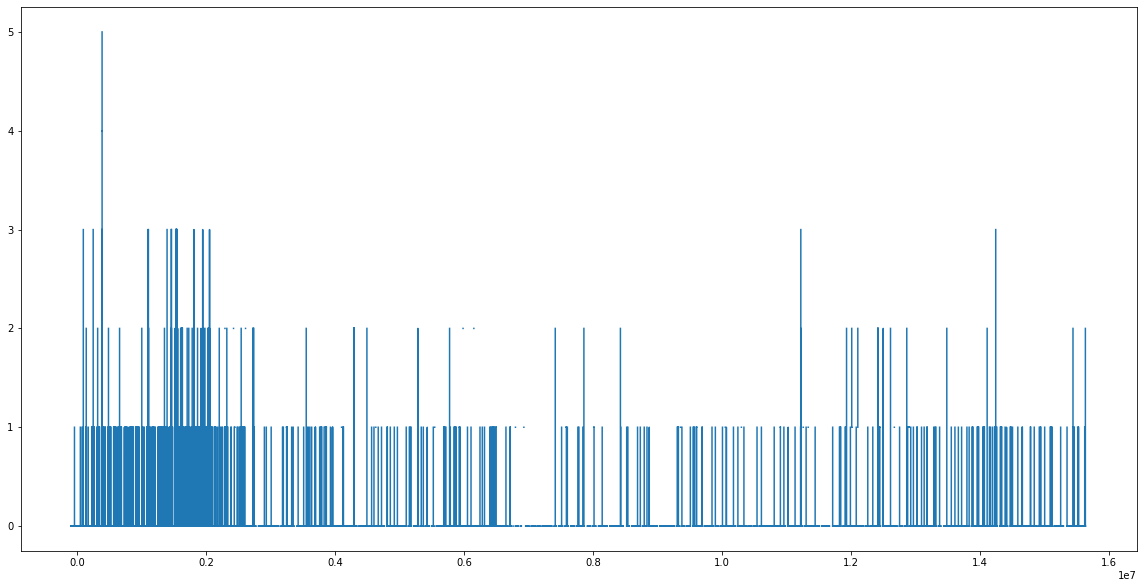

In [19]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()
ax.plot(df['TransactionDT'], df['V141'], linestyle='-')
plt.show()

In [21]:
column = 'V141'
s0 = df_transaction_train[ df_transaction_train['isFraud'] == 0 ][column]
s1 = df_transaction_train[ df_transaction_train['isFraud'] == 1 ][column]

print(ks_2samp(s0, s1))

Ks_2sampResult(statistic=0.03926196610525068, pvalue=4.00619209743477e-27)


In [22]:
print(s0.value_counts())

print(s0.isnull().sum())

a0 = s0[ ~s0.isna() ]
a1 = s1[ ~s1.isna() ]

print(ks_2samp(a0, a1))

0.0    75921
1.0     2144
2.0      200
3.0       26
5.0        2
4.0        2
Name: V141, dtype: int64
491582
Ks_2sampResult(statistic=0.06830891596324762, pvalue=1.46809891623235e-14)


In [23]:
#-------------------------------------------------------------------------------
# Computes the statistical distance between two samples using the KS-test.
# This is used to determine if the distribution of the attribute columns are
# statistically different when failure = 0 and failure = 1.
#-------------------------------------------------------------------------------

#from scipy.stats.mstats import ks_2samp as ks_2sampm

def compute_statistical_distance(df, feature):
    s0 = df[ df['isFraud'] == 0 ][feature]
    s1 = df[ df['isFraud'] == 1 ][feature]
    
    a0 = s0[ ~s0.isna() ]
    a1 = s1[ ~s1.isna() ]
    compare = ks_2samp(a0, a1)
    
    return ([feature, compare.statistic, compare.pvalue])

In [24]:
all_columns = df_transaction_train.columns.tolist()

In [25]:
cat_features = [
                'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
                'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9' 
              ]

excl_columns = cat_features + ['TransactionID', 'isFraud', 'TransactionDT']

In [26]:
len(excl_columns)

23

In [343]:
compare_lists = Parallel(n_jobs=20)(
                    delayed(compute_statistical_distance)(df_transaction_train, col) 
                    for col in all_columns if col not in excl_columns
                )

In [344]:
df_compare = pd.DataFrame.from_records(compare_lists, columns=['feature', 'statistic', 'pvalue'])

In [27]:
#df_compare.to_pickle('./data/pickles/df_kstest_comparison.pkl')
df_compare = pd.read_pickle('./data/pickles/df_kstest_comparison.pkl')

In [28]:
df_compare

feature  statistic         pvalue
0    TransactionAmt   0.075649   1.533201e-99
1             dist1   0.109743   3.564254e-49
2             dist2   0.073436   3.607917e-16
3                C1   0.187575   0.000000e+00
4                C2   0.204344   0.000000e+00
5                C3   0.004012   9.053311e-01
6                C4   0.330962   0.000000e+00
7                C5   0.287236   0.000000e+00
8                C6   0.132835  4.940649e-306
9                C7   0.278473   0.000000e+00
10               C8   0.316343   0.000000e+00
11               C9   0.292127   0.000000e+00
12              C10   0.311933   0.000000e+00
13              C11   0.185384   0.000000e+00
14              C12   0.296694   0.000000e+00
15              C13   0.188578   0.000000e+00
16              C14   0.198406   0.000000e+00
17               D1   0.210358   0.000000e+00
18               D2   0.324828   0.000000e+00
19               D3   0.361771   0.000000e+00
20               D4   0.194635   0.000000e+00
21               D5   0.437124   0.000000e+00
22               D6   0.083327   4.599517e-42
23               D7   0.269363  4.952942e-311
24               D8   0.313902   0.000000e+00
25               D9   0.122878   2.371097e-92
26              D10   0.262445   0.000000e+00
27              D11   0.159335  1.981049e-132
28              D12   0.119436   1.624867e-83
29              D13   0.072178   5.994248e-28
30              D14   0.128082   2.769698e-91
31              D15   0.248453   0.000000e+00
32               V1   0.000056   1.000000e+00
33               V2   0.024546   1.472879e-03
34               V3   0.075490   4.678843e-30
35               V4   0.035877   4.059724e-07
36               V5   0.069745   1.018949e-25
37               V6   0.013475   2.271492e-01
38               V7   0.039517   1.519167e-08
39               V8   0.015821   9.987610e-02
40               V9   0.053683   2.072680e-15
41              V10   0.280564   0.000000e+00
42              V11   0.280349   0.000000e+00
43              V12   0.172620   0.000000e+00
44              V13   0.175923   0.000000e+00
45              V14   0.000270   1.000000e+00
46              V15   0.326545   0.000000e+00
47              V16   0.326499   0.000000e+00
48              V17   0.317940   0.000000e+00
49              V18   0.318001   0.000000e+00
50              V19   0.049286   1.146921e-34
51              V20   0.054642   1.632063e-42
52              V21   0.314671   0.000000e+00
53              V22   0.314724   0.000000e+00
54              V23   0.094160  2.095075e-125
55              V24   0.093930  8.545803e-125
56              V25   0.008994   1.447153e-01
57              V26   0.019485   8.897092e-06
58              V27   0.000786   1.000000e+00
59              V28   0.000792   1.000000e+00
60              V29   0.305196   0.000000e+00
61              V30   0.305647   0.000000e+00
62              V31   0.320910   0.000000e+00
63              V32   0.320856   0.000000e+00
64              V33   0.345129   0.000000e+00
65              V34   0.352322   0.000000e+00
66              V35   0.218106   0.000000e+00
67              V36   0.219901   0.000000e+00
68              V37   0.202221   0.000000e+00
69              V38   0.246103   0.000000e+00
70              V39   0.361155   0.000000e+00
71              V40   0.362618   0.000000e+00
72              V41   0.000615   1.000000e+00
73              V42   0.354427   0.000000e+00
74              V43   0.356051   0.000000e+00
75              V44   0.240106   0.000000e+00
76              V45   0.266616   0.000000e+00
77              V46   0.081404   2.252820e-81
78              V47   0.129617  1.187216e-205
79              V48   0.316951   0.000000e+00
80              V49   0.317555   0.000000e+00
81              V50   0.368517   0.000000e+00
82              V51   0.386715   0.000000e+00
83              V52   0.390131   0.000000e+00
84              V53   0.167825   0.000000e+00
85              V54   0.167216   0.000000e+00
86        

In [29]:
numeric_features = sorted(df_compare[ df_compare['pvalue'] <= 0.01 ].sort_values(by='pvalue', ascending=False)['feature'].tolist())
len(numeric_features)

336

In [32]:
df_numeric = df_transaction_train[numeric_features].copy()

In [34]:
df_numeric.head()

C1  C10  C11  C12   C13  C14   C2   C4   C5   C6   C7   C8   C9     D1   D10    D11  D12  D13  D14    D15     D2    D3    D4   D5  D6  D7  D8  D9  TransactionAmt  V10  V100  V101  V102  V103  V104  V105  V106  V108  V109  V11  V110  V111  V112  V113  V114  V115  V116  V12  V123  V124  V125  V126    V127   V128  V129  V13   V130   V131  V132    V133   V134  V135  V136  V137  V138  V139  V140  V141  V142  V143  V144   V145  V146  V147  V148  V149  V15    V150  V151  V152  V153  V154  V155  V156  V157  V158          V159  V16           V160  V161  V162  V163   V164    V165    V166  V167  V168  V169  V17  V170  V171  V174  V175  V176  V177  V178  V179  V18  V180  V181  V182  V183  V184  V185  V186  V187  V188  V189  V19  V190  V191  V192  V193  V194  V195  V196  V197  V198  V199   V2  V20  V200  V201  V202  V203  V204  V208  V209  V21  V210  V211  V212  V213  V214  V215  V216  V217  V218  V219  V22  V220  V221  V222  V224  V225  V226  V227  V228  V229  V23  V230  V231  V232  V233  V234  V235  V236  V237  V238  V239  V24  V242  V243  V244  V245  V246  V247  V248  V249  V250  V251  V252  V253  V254  V255  V256  V257  V258  V259  V26  V260  V261  V262  V263  V264  V265  V267  V268  V270  V271  V272  V273  V274  V275  V276  V277  V278  V279  V280  V281  V282  V283  V284  V285  V287  V288  V289  V29  V290  V291  V292  V293  V294  V295  V296  V297  V298  V299   V3  V30  V300  V301  V302  V303  V304  V306    V307   V308  V309  V31   V310   V312  V313  V314  V315  V316    V317   V318  V319  V32  V320  V321  V322  V323  V324  V326  V327  V328  V329  V33  V330  V331  V332  V333  V335  V336  V337  V338  V339  V34  V35  V36  V37  V38  V39   V4  V40  V42  V43  V44  V45  V46  V47  V48  V49   V5  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V66  V67  V69   V7  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87   V9  V90  V91  V92  V93  V94  V95   V96   V97  V98   V99  dist1  dist2
0  1.0  0.0  2.0  0.0   1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   14.0  13.0   13.0  NaN  NaN  NaN    0.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN            68.5  0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   1.0  0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0   1.0   1.0   1.0   0.0   117.0    0.0   0.0  1.0    0.0    0.0   0.0   117.0    0.0   0.0   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN  0.0     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           NaN  0.0            NaN   NaN   NaN   NaN    NaN     NaN     NaN   NaN   NaN   NaN  0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  1.0  1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0  0.0   1.0   1.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  1.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   117.0    0.0   0.0  0.0    0.0    0.0   0.0   0.0   0.0   0.0   117.0    0.0   0.0  0.0   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  0.0  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0   0.0  0.0   0.0   19.0    NaN
1  1.0  0.0  1.0  0.0   1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   

In [35]:
corr_matrix = df_numeric.corr().abs()

In [36]:
corr_matrix.shape

(336, 336)

In [37]:
correlation_threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

In [39]:
to_drop

['C10',
 'C11',
 'C12',
 'C14',
 'C2',
 'C4',
 'C6',
 'C7',
 'C8',
 'D2',
 'D4',
 'D6',
 'D7',
 'V103',
 'V106',
 'V11',
 'V126',
 'V127',
 'V128',
 'V132',
 'V133',
 'V134',
 'V143',
 'V145',
 'V149',
 'V150',
 'V151',
 'V153',
 'V154',
 'V155',
 'V156',
 'V158',
 'V159',
 'V16',
 'V160',
 'V163',
 'V164',
 'V167',
 'V168',
 'V177',
 'V178',
 'V179',
 'V18',
 'V182',
 'V192',
 'V193',
 'V196',
 'V199',
 'V202',
 'V204',
 'V21',
 'V211',
 'V212',
 'V213',
 'V217',
 'V219',
 'V22',
 'V222',
 'V225',
 'V231',
 'V232',
 'V233',
 'V236',
 'V237',
 'V244',
 'V249',
 'V251',
 'V253',
 'V254',
 'V256',
 'V263',
 'V265',
 'V272',
 'V273',
 'V275',
 'V276',
 'V277',
 'V278',
 'V279',
 'V280',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V298',
 'V299',
 'V30',
 'V304',
 'V306',
 'V307',
 'V308',
 'V316',
 'V317',
 'V318',
 'V32',
 'V322',
 'V323',
 'V324',
 'V326',
 'V327',
 'V328',
 'V329',
 'V33',
 'V330',
 'V331',
 'V332',
 'V333',
 'V34',
 'V43',
 'V49',
 'V50',
 'V52',
 'V57',
 'V58',
 '

In [40]:
record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop
for column in to_drop:

            # Find the correlated features
    corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
    corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

            # Add to dataframe
    record_collinear = record_collinear.append(temp_df, ignore_index = True)

In [41]:
record_collinear

drop_feature corr_feature  corr_value
0            C10           C1    0.958202
1            C11           C1    0.996515
2            C11          C10    0.956056
3            C12          C10    0.983817
4            C14           C1    0.951761
5            C14          C11    0.962465
6             C2           C1    0.995089
7             C2          C10    0.970624
8             C2          C11    0.993898
9             C4           C1    0.967800
10            C4          C10    0.952466
11            C4          C11    0.974547
12            C4           C2    0.972134
13            C6           C1    0.982238
14            C6          C11    0.991105
15            C6          C14    0.984201
16            C6           C2    0.974845
17            C6           C4    0.962319
18            C7          C10    0.985062
19            C7          C12    0.999489
20            C8           C1    0.967746
21            C8          C10    0.996970
22            C8          C11    0.962722
23            C8          C12    0.983027
24            C8           C2    0.975863
25            C8           C4    0.959995
26            C8           C7    0.982983
27            D2           D1    0.981311
28            D4          D12    0.999999
29            D6          D12    0.976834
30            D6           D4    0.956966
31            D7           D5    0.986496
32          V103         V102    0.991516
33          V106         V105    0.960937
34           V11          V10    0.968670
35          V126         V101    0.981180
36          V127         V102    0.986570
37          V127         V103    0.978547
38          V128         V102    0.977778
39          V128         V103    0.985504
40          V128         V127    0.988974
41          V132         V101    0.995637
42          V132         V126    0.988348
43          V133         V102    0.995615
44          V133         V103    0.985672
45          V133         V127    0.992261
46          V133         V128    0.980590
47          V134         V102    0.989764
48          V134         V103    0.995735
49          V134         V127    0.985070
50          V134         V128    0.991355
51          V134         V133    0.991131
52          V143         V101    0.989884
53          V143         V126    0.975718
54          V143         V132    0.988088
55          V145         V144    0.952649
56          V149         V148    0.950232
57          V150         V144    0.958449
58          V150         V145    0.981799
59          V151         V150    0.972867
60          V153         V148    0.952071
61          V154         V153    0.986471
62          V155         V148    0.975978
63          V155         V153    0.960661
64          V156         V149    0.976168
65          V156         V155    0.953647
66          V158         V157    0.954520
67          V159         V150    0.968534
68          V159         V151    0.962705
69           V16          V15    0.986727
70          V160         V145    0.961669
71          V163         V162    0.953249
72          V164         V101    0.991996
73          V164         V126    0.980662
74          V164         V132    0.992538
75          V164         V143    0.996551
76          V167         V101    0.992058
77          V167         V126    0.985562
78          V167         V132    0.991856
79          V167         V143    0.982570
80          V167         V164    0.985778
81          V168         V102    0.975953
82          V168         V103    0.979765
83          V168         V127    0.972712
84          V168         V128    0.975078
85          V168         V133    0.974485
86          V168         V134    0.979748
87          V177         V101    0.992760
88          V177         V126    0.985724
89          V177         V132    0.992568
90          V177         V143    0.983420
91          V177         V164    0.986547
92          V177         V167    0.999364
93          V178         V102    0.989563
94          V1

In [348]:
# replacement methods

In [391]:
# imputation methods

def impute_missing_numeric(df, replace):
    for col in df.columns.tolist():
        df[col].fillna(replace[col], inplace=True)
        
def impute_missing_categorical(df):
    for col in df.columns.tolist():
        #df[col].fillna('NA', inplace=True)
        df[col] = df[col].map(lambda x: str(x).rstrip('.0'))

In [392]:
def prepare_training_data(df_transaction_train, numeric_features, cat_features):
    df_numeric_train = df_transaction_train[numeric_features].copy()
    df_categorical_train = df_transaction_train[cat_features].copy()
    
    # replacement strategy
    replace_num = np.mean(df_numeric_train)
    
    # imputation of missing fature values
    # imputing numeric features
    impute_missing_numeric(df_numeric_train, replace_num)
    
    # imputing categorical features
    impute_missing_categorical(df_categorical_train)
    
    encoding_cat = OneHotEncoder()
    encoding_cat.fit(df_categorical_train)
    df_categorical_train_enc = pd.DataFrame(
        encoding_cat.transform(df_categorical_train).toarray(), columns=encoding_cat.get_feature_names()
    )
    
    df_train = df_transaction_train[['TransactionID', 'isFraud']]
    df_train = pd.merge(df_train, df_categorical_train_enc, how='left', left_index=True, right_index=True)
    df_train = pd.merge(df_train, df_numeric_train, how='left', left_index=True, right_index=True)
    
    return (df_train, replace_num, encoding_cat)

In [394]:
df_transaction_test.head()

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  card3       card4  card5  card6  addr1  addr2   dist1  dist2 P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12    C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9    D10    D11  D12  D13  D14    D15 M1 M2 M3   M4   M5 M6   M7   M8   M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95  V96  V97  V98  V99  V100  V101  V102  V103  V104  V105  V106  V107  V108  V109  V110  V111  V112  V113  V114  V115  V116  V117  V118  V119  V120  V121  V122  V123  V124  V125       V126        V127       V128       V129        V130       V131  V132  V133  V134  V135   V136  V137  V138  V139  V140  V141  V142  V143  V144  V145  V146  V147  V148  V149  V150  V151  V152  V153  V154  V155  V156  V157  V158  V159  V160  V161  V162  V163  V164  V165  V166  V167  V168  V169  V170  V171  V172  V173  V174  V175  V176  V177  V178  V179  V180  V181  V182  V183  V184  V185  V186  V187  V188  V189  V190  V191  V192  V193  V194  V195  V196  V197  V198  V199  V200  V201  V202  V203  V204  V205  V206  V207  V208  V209  V210  V211  V212  V213  V214  V215  V216  V217  V218  V219  V220  V221  V222  V223  V224  V225  V226  V227  V228  V229  V230  V231  V232  V233  V234  V235  V236  V237  V238  V239  V240  V241  V242  V243  V244  V245  V246  V247  V248  V249  V250  V251  V252  V253  V254  V255  V256  V257  V258  V259  V260  V261  V262  V263  V264  V265  V266  V267  V268  V269  V270  V271  V272  V273  V274  V275  V276  V277  V278  V279  V280  V281  V282  V283  V284  V285  V286  V287  V288  V289  V290  V291  V292  V293  V294  V295  V296  V297  V298  V299  V300  V301  V302  V303  V304  V305       V306         V307       V308       V309         V310       V311       V312        V313        V314        V315  V316  V317  V318  V319   V320  V321  V322  V323  V324  V325  V326  V327  V328  V329  V330  V331  V332  V333  V334  V335  V336  V337  V338  V339
0        3663549       18403224           31.95         W  10409  111.0  150.0        visa  226.0  debit  170.0   87.0     1.0    NaN     gmail.com           NaN  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0  1.0  115.0  6.0  419.0  419.0  27.0  398.0  27.0 NaN NaN NaN NaN  418.0  203.0  NaN  NaN  NaN  409.0  T  T  F  NaN  NaN  F    T    T    T  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.000000   47.950001   0.000000   0.000000   47.950001   0.000000   0.0   0.0   0.0   0.0    0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [395]:
def prepare_testing_data(
        df_transaction_test, numeric_features, cat_features, replace_num, encoding_cat
):
    df_numeric_test = df_transaction_test[numeric_features].copy()
    df_categorical_test = df_transaction_test[cat_features].copy()
    
    # imputation of missing values
    # numeric features
    impute_missing_numeric(df_numeric_test, replace_num)
    
    # imputing categorical features
    impute_missing_categorical(df_categorical_test)
    df_categorical_test_enc = pd.DataFrame(
        encoding_cat.transform(df_categorical_test).toarray(), columns=encoding_cat.get_feature_names()
    )
    
    df_test = df_transaction_test[['TransactionID']]
    df_test = pd.merge(df_test, df_categorical_test_enc, how='left', left_index=True, right_index=True)
    df_test = pd.merge(df_test, df_numeric_test, how='left', left_index=True, right_index=True)
    
    return (df_test)

In [393]:
df_train, replace_num, encoding_cat = prepare_training_data(df_transaction_train, numeric_features, cat_features)

In [396]:
df_train.to_pickle('./data/pickles/df_train.pkl')

In [399]:
df_train.shape

(590540, 14664)

In [398]:
df_train.head()

TransactionID  isFraud  x0_C  x0_H  x0_R  x0_S  x0_W  x1_1  x1_10003  x1_10004  x1_10005  x1_10006  x1_10007  x1_10008  x1_10009  x1_1001  x1_10011  x1_10012  x1_10013  x1_10015  x1_10016  x1_10017  x1_10018  x1_10019  x1_1002  x1_10021  x1_10022  x1_10023  x1_10024  x1_10025  x1_10027  x1_10028  x1_10029  x1_10032  x1_10034  x1_10035  x1_10036  x1_10037  x1_10038  x1_10039  x1_1004  x1_10041  x1_10042  x1_10043  x1_10044  x1_10045  x1_10047  x1_10048  x1_10049  x1_1005  x1_10051  x1_10052  x1_10053  x1_10054  x1_10056  x1_10057  x1_10058  x1_1006  x1_10063  x1_10065  x1_10066  x1_10067  x1_10068  x1_10069  x1_1007  x1_10071  x1_10072  x1_10073  x1_10075  x1_10076  x1_10077  x1_10078  x1_10079  x1_1008  x1_10082  x1_10083  x1_10084  x1_10085  x1_10086  x1_10087  x1_1009  x1_10091  x1_10094  x1_10095  x1_10096  x1_10097  x1_101  x1_10101  x1_10102  x1_10103  x1_10104  x1_10106  x1_10107  x1_10108  x1_1011  x1_10111  x1_10112  x1_10113  x1_10114  x1_10117  x1_10119  x1_1012  x1_10121  x1_10122  x1_10123  x1_10127  x1_10128  x1_1013  x1_10131  x1_10132  x1_10133  x1_10134  x1_10135  x1_10136  x1_10137  x1_10138  x1_1014  x1_10141  x1_10142  x1_10144  x1_10145  x1_10146  x1_10147  x1_10148  x1_10149  x1_1015  x1_10151  x1_10152  x1_10153  x1_10154  x1_10155  x1_10156  x1_10157  x1_10159  x1_1016  x1_10162  x1_10163  x1_10164  x1_10165  x1_10166  x1_10167  x1_10168  x1_10169  x1_1017  x1_10171  x1_10172  x1_10173  x1_10175  x1_10176  x1_10177  x1_10179  x1_1018  x1_10181  x1_10182  x1_10183  x1_10184  x1_10185  x1_10186  x1_10187  x1_10188  x1_1019  x1_10191  x1_10192  x1_10193  x1_10196  x1_10197  x1_10199  x1_102  x1_10201  x1_10202  x1_10203  x1_10204  x1_10205  x1_10206  x1_10207  x1_10209  x1_1021  x1_10212  x1_10213  x1_10214  x1_10215  x1_10216  x1_10218  x1_10219  x1_1022  x1_10221  x1_10222  x1_10223  x1_10224  x1_10225  x1_10226  x1_10227  x1_10228  x1_10229  x1_1023  x1_10231  x1_10232  x1_10233  x1_10234  x1_10235  x1_10236  x1_10238  x1_10239  x1_1024  x1_10241  x1_10242  x1_10244  x1_10245  x1_10246  x1_10247  x1_10248  x1_10249  x1_1025  x1_10251  x1_10252  x1_10254  x1_10255  x1_10256  x1_10258  x1_10259  x1_1026  x1_10262  x1_10265  x1_10267  x1_10269  x1_1027  x1_10271  x1_10272  x1_10273  x1_10274  x1_10275  x1_10276  x1_10277  x1_10278  x1_1028  x1_10281  x1_10282  x1_10283  x1_10284  x1_10285  x1_10286  x1_10288  x1_10289  x1_1029  x1_10291  x1_10292  x1_10293  x1_10294  x1_10295  x1_10296  x1_10297  x1_10298  x1_103  x1_10301  x1_10303  x1_10304  x1_10305  x1_10306  x1_10308  x1_10309  x1_1031  x1_10311  x1_10312  x1_10313  x1_10314  x1_10315  x1_10316  x1_10317  x1_10318  x1_10319  x1_1032  x1_10321  x1_10322  x1_10323  x1_10324  x1_10325  x1_10326  x1_10327  x1_10328  x1_1033  x1_10331  x1_10332  x1_10333  x1_10334  x1_10337  x1_10338  x1_10339  x1_1034  x1_10341  x1_10342  x1_10344  x1_10345  x1_10346  x1_10347  x1_10348  x1_10349  x1_1035  x1_10351  x1_10353  x1_10354  x1_10355  x1_10356  x1_10357  x1_10358  x1_10359  x1_1036  x1_10361  x1_10362  x1_10363  x1_10364  x1_10365  x1_10366  x1_10367  x1_10368  x1_10369  x1_1037  x1_10371  x1_10372  x1_10373  x1_10374  x1_10376  x1_10377  x1_10378  x1_10379  x1_1038  x1_10383  x1_10385  x1_10389  x1_1039  x1_10391  x1_10392  x1_10393  x1_10394  x1_10395  x1_10396  x1_10398  x1_10399  x1_104  x1_10401  x1_10405  x1_10406  x1_10407  x1_10408  x1_10409  x1_1041  x1_10413  x1_10414  x1_10415  x1_10416  x1_10417  x1_1042  x1_10422  x1_10425  x1_10427  x1_10429  x1_1043  x1_10431  x1_10432  x1_10433  x1_10434  x1_10435  x1_10436  x1_10437  x1_10439  x1_10441  x1_10444  x1_10445  x1_10446  x1_10447  x1_10448  x1_10449  x1_1045  x1_10454  x1_10456  x1_10457  x1_10458  x1_10459  x1_1046  x1_10461  x1_10462  x1_10464  x1_10465  x1_10466  x1_10467  x1_10468  x1_10469  x1_1047  x1_10471  x1_10472  x1_10473  x1_10474  x1_10475  x1_10476  x1_10477  x1_10478  x1_1048  x1_10482  x1_10484  x1_10485  x1_10486  x1_10487  x1_10488  x1_10489  x1_1049  x1_10491  x1_10492  x1_10493  x

In [387]:
# step-by-step execution of prepare_training_data() ... for debugging purposes
if 0:
    df_numeric_train = df_transaction_train[numeric_columns].copy()
    df_numeric_train.head()
    replace = np.mean(df_numeric_train)
    impute_missing_numeric(df_numeric_train, replace)
    df_categorical_train = df_transaction_train[cat_columns].copy()
    df_categorical_train.head()
    impute_missing_categorical(df_categorical_train)
    df_categorical_train.shape

    df_sub_train = df_transaction_train[['TransactionID', 'isFraud']]
    df_sub_train = pd.merge(df_sub_train, df_categorical_train, how='left', left_index=True, right_index=True)
    df_sub_train = pd.merge(df_sub_train, df_numeric_train, how='left', left_index=True, right_index=True)
    df_sub_train.head()

In [ ]:
df_test = prepare_testing_data(df_transaction_test, numeric_features, cat_features, replace_num, encoding_cat)

In [240]:
crossvalidation = StratifiedKFold(n_splits = 3)
scoring_metrics = {
                    'Accuracy': 'accuracy',
                    'Recall': 'recall',
                    'Precision': 'precision',
                    'F1': 'f1',
                    'AUC': 'roc_auc'
                  }

In [254]:
#-------------------------------------------------------------------------------
# Instantiate the machine learning models with their respective parameters for
# cross-validation.
#-------------------------------------------------------------------------------
def instantiate(model_type):
    if model_type == 'Decision Tree':
        MAX_HEIGHT = 20
        model = DecisionTreeClassifier(random_state=0)
        model_parameter_grid = {
         'max_depth': range(1,(MAX_HEIGHT+1))
        }
    elif model_type == 'Neural Network':
        NUM_HIDDEN_LAYERS = 2
        NUM_HIDDEN_NODES_PER_LAYER = 4
        model = MLPClassifier(
                  solver='adam',
                  activation='logistic',
                  alpha=0.1,
                  learning_rate='adaptive',
                  shuffle=False,
                  random_state=0
                )
        model_parameter_grid = {
          #'activation': ['identity', 'logistic', 'tanh'],
          #'learning_rate': ['invscaling', 'adaptive'],
          #'alpha': [0.01, 0.1, 1.0],
          'hidden_layer_sizes': [x for x in itertools.product((range(1,(NUM_HIDDEN_NODES_PER_LAYER+1))), repeat=NUM_HIDDEN_LAYERS)]
        }
    elif model_type == 'Logistic Regression':
        model = LogisticRegression(
                    class_weight='balanced',
                    random_state=0
                )
        model_parameter_grid = {
            'C': [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 2, 5, 10]
        }
    elif model_type == 'Random Forest':
        MAX_HEIGHT = 10
        NUM_TREES = 10
        model = RandomForestClassifier(random_state=0, class_weight='balanced')
        model_parameter_grid = {
          'max_depth': range(1,(MAX_HEIGHT+1)),
          'n_estimators': [x for x in range(1, (NUM_TREES+1))]
        }

    return model, model_parameter_grid

In [255]:
#-------------------------------------------------------------------------------
# Execute the cross-validation for all parameter combinations and plots the
# evaluation metrics. At each iteration of the cross validation process, the 
# model is evaluated using all the below metrics but the optimal model is 
# determined using the AUC score (as this minimizes both false positives &
# false negatives).
#-------------------------------------------------------------------------------
def build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics):
    grid_object = GridSearchCV(model, param_grid=model_parameter_grid, cv=crossvalidation, scoring=scoring_metrics, refit='AUC', return_train_score=True, n_jobs=-1)
    print('Performing grid search to determine the optimal parameters ...')
    grid_object.fit(X, y)
    grid_search_output = pd.DataFrame(grid_object.cv_results_)
    grid_search_output[['params', 'mean_test_AUC', 'rank_test_AUC', 'mean_test_Recall', 'rank_test_Recall', 'mean_test_Accuracy', 'rank_test_Accuracy']]

    if model_type == 'Decision Tree':
        MAX_HEIGHT = 20
        plot_cross_validation_output(grid_search_output, scoring_metrics, MAX_HEIGHT)

    optimal_model = grid_object.best_estimator_
    optimal_model = optimal_model.fit(X, y)

    return grid_search_output, optimal_model


In [261]:
#-------------------------------------------------------------------------------
# Graphs the outputs of the cross-validation optimization process for the
# __Decision Tree__ model (this function can be extended to any model which has a
# single changeable hyperparameter).
#
# Produces comparison of the different evaluation metrics for
# training & testing data splits.
#-------------------------------------------------------------------------------
def plot_cross_validation_output(grid_search_output, scoring_metrics, max_height):
    fig = plt.figure()
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=12)

    plt.xlabel("DecisionTree Height")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xticks(np.linspace(0, max_height, max_height+1))
    ax.set_ylim(0, 1.05)

    # Set X-axis to be the Decision Tree height
    X_axis = np.array(grid_search_output['param_max_depth'], dtype=int)

    for scorer, color in zip(scoring_metrics, ['r', 'b', 'm', 'g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = grid_search_output['mean_%s_%s' % (sample, scorer)]
            sample_score_std = grid_search_output['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(grid_search_output['rank_test_%s' % scorer] == 1)[0][0]
        best_score = grid_search_output['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    #plt.legend(loc="best")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid('off')
    plt.show()

    results_dir = './data/results/'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    filename = 'decision_tree_evaluation.png'
    filepath= os.path.join(results_dir, filename)
    fig.savefig(filepath, bbox_inches = 'tight')


In [257]:
df_sub.head()
train_features = df_sub.columns.tolist()[2:]

In [258]:
# Decision Tree
model_type = 'Decision Tree'
model, model_parameter_grid = instantiate(model_type)

In [259]:
X = df_sub[train_features]
y = df_sub['isFraud']

In [260]:
grid_search_output, optimal_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, crossvalidation, scoring_metrics)

Performing grid search to determine the optimal parameters ...


ValueError: could not convert string to float: 'W'

In [2]:
dfw = df_transaction_train[['TransactionID', 'isFraud', 'card4']]

NameError: name 'df_transaction_train' is not defined

In [403]:
dfw.isnull().any()

isFraud    False
card4       True
dtype: bool

In [413]:
sum(dfw['card4'].value_counts())

588963

In [414]:
dfw.shape

(590540, 3)

In [415]:
sum(dfw['card4'].isnull())

1577

In [1]:
dfw.groupby(['card4', 'isFraud']).count().reset_index(inplace=True)

NameError: name 'dfw' is not defined